In [ ]:
import numpy as np
import cv2
from torch.utils.data import random_split
from torchvision.models import vgg19
import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from brisque import BRISQUE
from dataset import EXRDataset
import torch.nn.functional as F

In [118]:
# enable using OpenEXR with OpenCV
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = "1"

FILE_PATH = os.path.normpath("./data/reference/001.exr")

def read_exr(im_path: str) -> np.ndarray:
    return cv2.imread(
    filename=im_path,
    flags=cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH
    )
def tone_map_reinhard(image: np.ndarray) -> np.ndarray:
    tonemap_operator = cv2.createTonemapReinhard(
    gamma=2.2,
    intensity=0.0,
    light_adapt=0.0,
    color_adapt=0.0
    )
    result = tonemap_operator.process(src=image)
    return result
def tone_map_mantiuk(image: np.ndarray) -> np.ndarray:
    tonemap_operator = cv2.createTonemapMantiuk(
    gamma=2.2,
    scale=0.85,
    saturation=1.2
    )
    result = tonemap_operator.process(src=image)
    return result

def evaluate_image(image: np.ndarray) -> float:
    metric = BRISQUE(url=False)
    return metric.score(img=image)

def fix_colors(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def clip(img):
    return np.clip(img / np.max(img), 0, 1)

tone_mapped_reinhard 29.354828577540246
tone_mapped_mantiuk 28.249648504367286


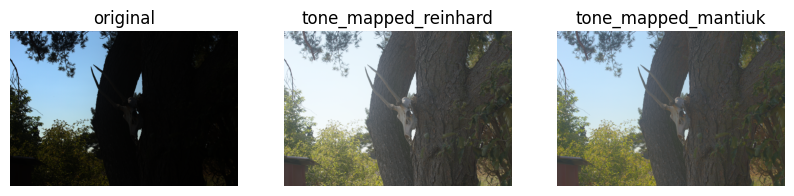

In [119]:
image = read_exr(im_path=FILE_PATH)
tone_mapped_reinhard = tone_map_reinhard(image)
tone_mapped_mantiuk = tone_map_mantiuk(image)

fig, axes = plt.subplots(1, 3, figsize=(10, 5)) 

axes[0].imshow(fix_colors(clip(image)))
axes[0].axis('off')
axes[0].set_title("original")

axes[1].imshow(fix_colors(tone_mapped_reinhard))
axes[1].axis('off')
axes[1].set_title("tone_mapped_reinhard")

axes[2].imshow(fix_colors(tone_mapped_mantiuk))
axes[2].axis('off')
axes[2].set_title("tone_mapped_mantiuk")

print('tone_mapped_reinhard', evaluate_image(image=tone_mapped_reinhard))
print('tone_mapped_mantiuk', evaluate_image(image=tone_mapped_mantiuk))

# 3.1 Multiple Exposure Selection

In [37]:
def aces_estimation(t=0.85, A=2.51, B=0.03, C=2.43, D=0.59, E=0.14):
    # (tC - A)x^2 + (tD - B)x + tE = 0
    a = t * C - A
    b = t * D - B
    c = t * E

    delta = b ** 2 - 4 * a * c
    return (-b - np.sqrt(delta)) / (2 * a)

def exposures(img: torch.Tensor):
    x_p = aces_estimation()

    c_start = torch.log(x_p / torch.max(img))

    percentile_50 = torch.quantile(img, 0.5)
    c_end = torch.log2(x_p / percentile_50)

    output_list = []
    exp_value = [c_start, (c_end + c_start) / 2.0, c_end]
    for value in exp_value:
        sc = torch.pow(torch.sqrt(torch.tensor(2.0)), value)
        img_exp = img * sc
        img_out = torch.clip(img_exp, 0, 1)
        output_list.append(img_out)

    return output_list

Text(0.5, 1.0, 'I-e-high')

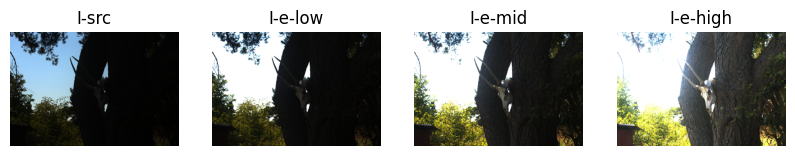

In [38]:
def normalize(img):
    return img * (0.5 / np.mean(img))

img_low, img_mid, img_high = exposures(torch.from_numpy(normalize(image)))

fig, axes = plt.subplots(1, 4, figsize=(10, 10)) 

axes[0].imshow(fix_colors(normalize(image)))
axes[0].axis('off')
axes[0].set_title("I-src")


axes[1].imshow(fix_colors(img_low.detach().cpu().numpy()))
axes[1].axis('off')
axes[1].set_title("I-e-low")

axes[2].imshow(fix_colors(img_mid.detach().cpu().numpy()))
axes[2].axis('off')
axes[2].set_title("I-e-mid")

axes[3].imshow(fix_colors(img_high.detach().cpu().numpy()))
axes[3].axis('off')
axes[3].set_title("I-e-high")

# 3.2 Tone Mapping Network

In [39]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Conv2d(192, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, exp1, exp2, exp3):
        x = self.decoder(x)
        residual = x + exp1 + exp2 + exp3
        return self.sigmoid(residual)
    

class SelfTMO(nn.Module):
    def __init__(self):
        super(SelfTMO, self).__init__()

        # 1 instance of encoder to share the weights
        self.encoder = Encoder()
        
        self.fusion = nn.Sequential(
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(192, 192, kernel_size=1, stride=1)
        )

        self.decoder = Decoder()

    def forward(self, exp1, exp2, exp3):
        exp1_enc = self.encoder(exp1)
        exp2_enc = self.encoder(exp2)
        exp3_enc = self.encoder(exp3)

        concat = torch.concat([exp1_enc, exp2_enc, exp3_enc], axis = 0)
        
        concat = self.fusion(concat)
        concat = self.decoder(concat, exp1, exp2, exp3)

        return concat

# 3.3 Adaptive μ-law compression

In [40]:
def mi_law(input, lambda1=8.759, lambda2=0.1494, gamma1=2.148, gamma2=-2.067):
    return lambda1 * (input ** gamma1) + lambda2 * (input ** gamma2)

def mi_img(img: np.ndarray):
    law_value = mi_law(img)
    return torch.log(1+law_value*img)/torch.log(1+law_value)

# 3.4 Feature Contrast Masking Loss

# Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)

cpu


In [ ]:
def feature_contrast(feature_map, patch_size=13, epsilon=1e-6):
    kernel = torch.ones(1, 1, patch_size, patch_size, device=feature_map.device) / (patch_size ** 2)
    
    gauss = F.conv2d(feature_map.unsqueeze(0).unsqueeze(0), kernel, padding=patch_size//2)
    
    return (feature_map - gauss.squeeze(0).squeeze(0)) / (torch.abs(gauss.squeeze(0).squeeze(0)) + epsilon)



def feature_contrast_self_masking(feature_map, alpha):  # mi: alpha=0.5, TM: alpha=1
    C = feature_contrast(feature_map)
    return torch.sign(C)*abs(C)**alpha


def feature_contrast_neighborhood_masking(feature_map, patch_size=13, epsilon=1e-6):
    kernel = torch.ones((1, 1, patch_size, patch_size), dtype=torch.float32, device=feature_map.device) / (patch_size ** 2)
    
    mi_b = F.conv2d(feature_map.unsqueeze(0), kernel, padding=patch_size//2)
    
    feature_map_squared = feature_map ** 2
    mi_b_squared = F.conv2d(feature_map_squared.unsqueeze(0), kernel, padding=patch_size//2)
    
    sigma_b = torch.sqrt(mi_b_squared - mi_b ** 2 + epsilon)
    
    contrast_map = sigma_b / (torch.abs(mi_b) + epsilon)
    
    return contrast_map.squeeze(0)

    
def f(Ms, Mn):
    return Ms / (1+Mn)

model_vgg19 = vgg19(pretrained=True).to(device)

def loss(I_mi, I_tm):
    mi_vgg = model_vgg19(I_mi.unsqueeze(0))
    tm_vgg = model_vgg19(I_tm.unsqueeze(0))
    return torch.abs(
        f(feature_contrast_self_masking(mi_vgg, 0.5), feature_contrast_neighborhood_masking(mi_vgg)) - 
        f(feature_contrast_self_masking(tm_vgg, 1), feature_contrast_neighborhood_masking(tm_vgg))
    )

In [47]:
model = SelfTMO()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [44]:
dataset = EXRDataset("./data/processed")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [48]:
num_epochs = 400
losses = {"train":[],"val":[]}

for epoch in range(num_epochs):
    model.train()
    for img in tqdm.tqdm(train_dataset):
        optimizer.zero_grad()

        img = img.to(device)

        img_low, img_mid, img_high = exposures(img)

        I_tm = model(img_low, img_mid, img_high)
        I_mi = mi_img(img)

        a = loss(I_mi, I_tm)
        a.mean().backward()
        optimizer.step()
    
    model.eval()
    print(f"epoch #{epoch+1}, loss: {a.mean()}")
    losses["train"].append(loss)
    with torch.no_grad():
        total_loss = 0.0
        for img in val_dataset:
            img_low, img_mid, img_high = exposures(img)
            I_tm = model(img_low, img_mid, img_high)

            I_mi = mi_img(img)

            a = loss(I_mi, I_tm)
            total_loss += a.mean()
        print("Validation loss:",total_loss)
    losses["val"].append(total_loss)

    if (epoch + 1) % 10 == 0:
        scheduler.step()

  0%|          | 0/16 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [1, 1, 13, 13], expected input[1, 128, 128, 128] to have 1 channels, but got 128 channels instead

In [ ]:
def lum(img):
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    l = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return l

def color_correction(img_in, img_out, s=0.6):
    l_in = lum(img_in)
    l_out = lum(img_out)

    l_in = l_in[..., np.newaxis]
    l_out = l_out[..., np.newaxis]

    return l_out * (img_in / l_in) ** s

In [ ]:
# torch.save(model, 'test.pth')

In [112]:
image=val_dataset[3]

img_low, img_mid, img_high = exposures(image)
image=np.clip(image.numpy().transpose(1, 2, 0), 0, 1)

result = np.clip(model(img_low, img_mid, img_high).detach().numpy().transpose(1, 2, 0), 0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.20064108..1.2951648].


tone_mapped_reinhard 36.762512191894274
tone_mapped_mantiuk 32.29299087046704
model 23.387202331102998


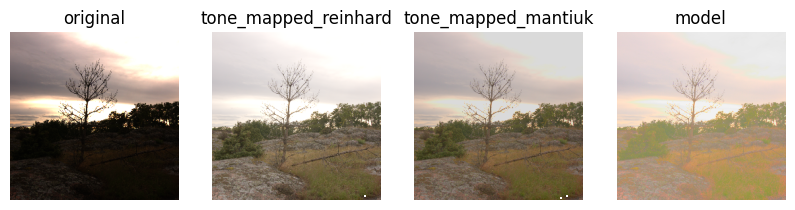

In [113]:
tone_mapped_reinhard = tone_map_reinhard(image)
tone_mapped_mantiuk = tone_map_mantiuk(image)

fig, axes = plt.subplots(1, 4, figsize=(10, 10)) 

axes[0].imshow(fix_colors(image))
axes[0].axis('off')
axes[0].set_title("original")

axes[1].imshow(fix_colors(tone_mapped_reinhard))
axes[1].axis('off')
axes[1].set_title("tone_mapped_reinhard")

axes[2].imshow(fix_colors(tone_mapped_mantiuk))
axes[2].axis('off')
axes[2].set_title("tone_mapped_mantiuk")

axes[3].imshow(fix_colors(color_correction(image, result)))
axes[3].axis('off')
axes[3].set_title("model")

print('tone_mapped_reinhard', evaluate_image(image=tone_mapped_reinhard))
print('tone_mapped_mantiuk', evaluate_image(image=tone_mapped_mantiuk))
print('model', evaluate_image(image=result))